In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil
import random

# def split_class_data(class_dir, train_ratio=0.7, test_ratio=0.15, val_ratio=0.15):
#     files = os.listdir(class_dir)
#     random.shuffle(files)

#     train_size = int(len(files) * train_ratio)
#     test_size = int(len(files) * test_ratio)
#     val_size = len(files) - train_size - test_size

#     train_files = files[:train_size]
#     test_files = files[train_size:train_size + test_size]
#     val_files = files[train_size + test_size:]

#     return train_files, test_files, val_files

# def split_dataset(base_dir, output_dir, class_names, train_ratio=0.7, test_ratio=0.15, val_ratio=0.15):
#     for class_name in class_names:
#         class_dir = os.path.join(base_dir, class_name)
#         train_files, test_files, val_files = split_class_data(class_dir, train_ratio, test_ratio, val_ratio)

#         os.makedirs(os.path.join(output_dir, 'train', class_name), exist_ok=True)
#         os.makedirs(os.path.join(output_dir, 'test', class_name), exist_ok=True)
#         os.makedirs(os.path.join(output_dir, 'val', class_name), exist_ok=True)

#         for file in train_files:
#             shutil.copy(os.path.join(class_dir, file), os.path.join(output_dir, 'train', class_name, file))

#         for file in test_files:
#             shutil.copy(os.path.join(class_dir, file), os.path.join(output_dir, 'test', class_name, file))

#         for file in val_files:
#             shutil.copy(os.path.join(class_dir, file), os.path.join(output_dir, 'val', class_name, file))

#     print("Dataset split into train, test, and validation sets.")

# base_dir = '/content/drive/MyDrive/eye disease detection/dataset'
# output_dir = '/content/drive/MyDrive/eye disease detection/split_dataset'
# class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# split_dataset(base_dir, output_dir, class_names)


In [ ]:
folders = os.listdir('/content/drive/MyDrive/eye disease detection/split_dataset/train')


In [ ]:
folders

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [ ]:
path = '/content/drive/MyDrive/eye disease detection/split_dataset/train/'
for i in folders:
  print(i, len(os.listdir(path+i)))


cataract 726
diabetic_retinopathy 768
glaucoma 718
normal 779


In [ ]:
folders_val = os.listdir('/content/drive/MyDrive/eye disease detection/split_dataset/val')
folders_val

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [ ]:
path = '/content/drive/MyDrive/eye disease detection/split_dataset/val/'
for i in folders:
  print(i, len(os.listdir(path+i)))


cataract 157
diabetic_retinopathy 166
glaucoma 155
normal 168


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

class_names = ['cataract','diabetic_retinopathy', 'glaucoma', 'normal']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)



In [ ]:
train_dir = '/content/drive/MyDrive/eye disease detection/split_dataset/train'
test_dir = '/content/drive/MyDrive/eye disease detection/split_dataset/val'

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [ ]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=50,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7081 | train_acc: 0.7135 | test_loss: 0.5641 | test_acc: 0.7728
Epoch: 2 | train_loss: 0.5254 | train_acc: 0.7984 | test_loss: 0.4878 | test_acc: 0.8056
Epoch: 3 | train_loss: 0.4544 | train_acc: 0.8381 | test_loss: 0.4528 | test_acc: 0.8318
Epoch: 4 | train_loss: 0.4179 | train_acc: 0.8553 | test_loss: 0.4337 | test_acc: 0.8294
Epoch: 5 | train_loss: 0.3880 | train_acc: 0.8613 | test_loss: 0.4322 | test_acc: 0.8323
Epoch: 6 | train_loss: 0.3709 | train_acc: 0.8702 | test_loss: 0.3962 | test_acc: 0.8517
Epoch: 7 | train_loss: 0.3524 | train_acc: 0.8760 | test_loss: 0.4019 | test_acc: 0.8487
Epoch: 8 | train_loss: 0.3421 | train_acc: 0.8816 | test_loss: 0.3833 | test_acc: 0.8457
Epoch: 9 | train_loss: 0.3305 | train_acc: 0.8842 | test_loss: 0.3873 | test_acc: 0.8566
Epoch: 10 | train_loss: 0.3186 | train_acc: 0.8929 | test_loss: 0.3751 | test_acc: 0.8487
Epoch: 11 | train_loss: 0.3099 | train_acc: 0.8925 | test_loss: 0.3659 | test_acc: 0.8591
Epoch: 12 | train_l

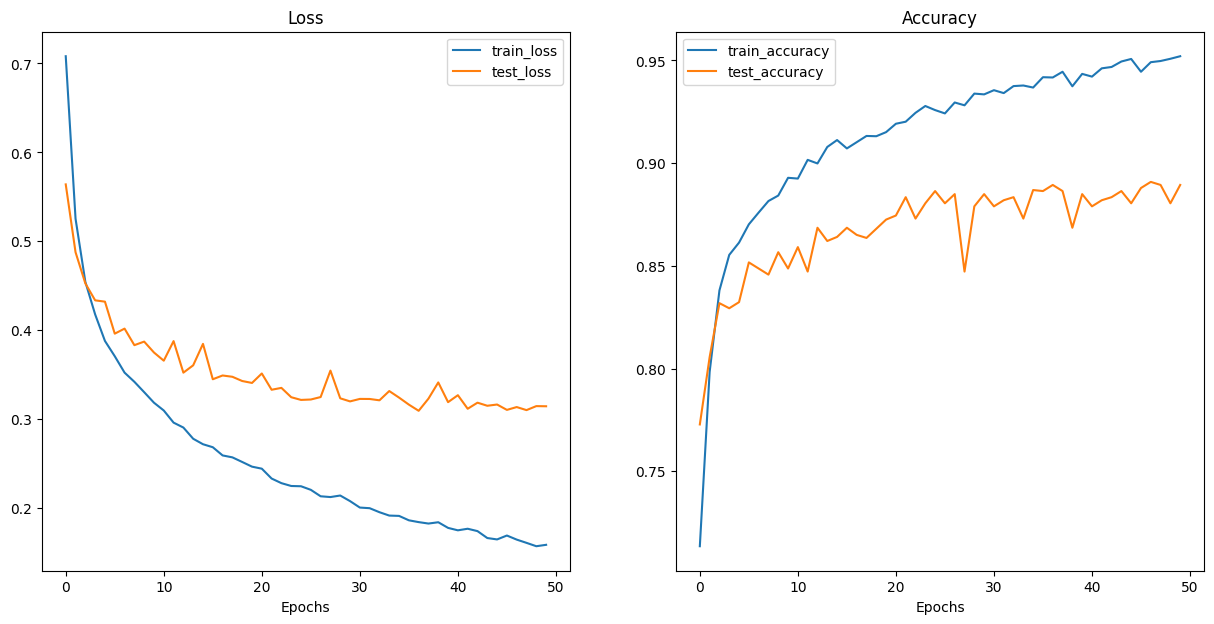

In [ ]:
plot_loss_curves(pretrained_vit_results)


Overall Accuracy: 0.8916

Class: cataract
Accuracy: 0.9490
F1 Score: 0.9113
Precision: 0.8765
Recall: 0.9490

Class: diabetic_retinopathy
Accuracy: 0.9639
F1 Score: 0.9581
Precision: 0.9524
Recall: 0.9639

Class: glaucoma
Accuracy: 0.7548
F1 Score: 0.8182
Precision: 0.8931
Recall: 0.7548

Class: normal
Accuracy: 0.8929
F1 Score: 0.8696
Precision: 0.8475
Recall: 0.8929


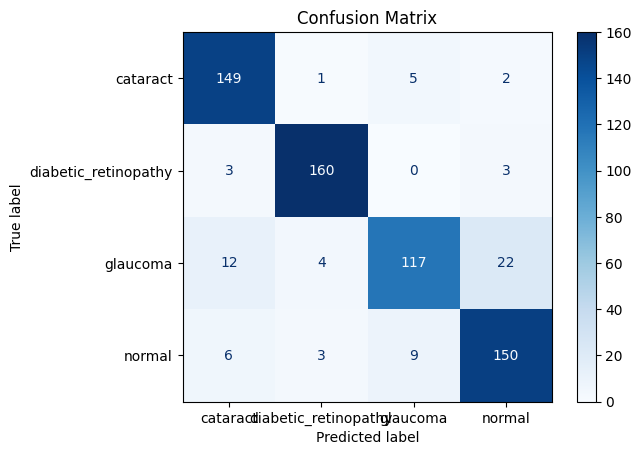

In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def evaluate_model(model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   device: torch.device) -> None:

    # Put the model in evaluation mode
    model.eval()

    all_labels = []
    all_preds = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred_labels = torch.argmax(y_pred, dim=1)
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(y_pred_labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average=None)  # F1 score for each class
    precision = precision_score(all_labels, all_preds, average=None)  # Precision for each class
    recall = recall_score(all_labels, all_preds, average=None)  # Recall for each class
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Overall Accuracy: {accuracy:.4f}")
    for i, class_name in enumerate(class_names):
        print(f"\nClass: {class_name}")
        print(f"Accuracy: {(conf_matrix[i, i] / conf_matrix[i].sum()):.4f}")
        print(f"F1 Score: {f1[i]:.4f}")
        print(f"Precision: {precision[i]:.4f}")
        print(f"Recall: {recall[i]:.4f}")

    return conf_matrix
# Evaluate the model and get the confusion matrix
conf_matrix = evaluate_model(model=pretrained_vit,
                             dataloader=test_dataloader_pretrained,
                             device=device)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from PIL import Image

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

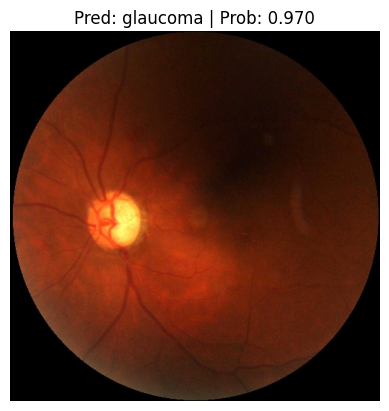

In [ ]:
import requests

custom_image_path = '/content/drive/MyDrive/eye disease detection/split_dataset/test/glaucoma/1318_left.jpg'

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)